## Data Analysis of Head Start Accessibility and Impact across the Continental U.S.

- Presented by team <b>Data Miners</b> for <b>2023 AGA Datathon</b>

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import math
import sys
import geopy.distance
from itertools import combinations
from sklearn.linear_model import LinearRegression

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Loading Datasets

##### List of data source:
- Head Start Program Facts: Fiscal Year 2021: https://eclkc.ohs.acf.hhs.gov/about-us/article/head-start-program-facts-fiscal-year-2021

- Head Start Center Locations: https://eclkc.ohs.acf.hhs.gov/sites/default/files/locatordata/ALL_all.csv

- SAIPE Child Poverty Data: https://www.census.gov/data/datasets/2021/demo/saipe/2021-state-and-county.html

- U.S. States Economic Data: https://apps.bea.gov/regional/downloadzip.cfm

In [225]:
df_state_abbr = pd.read_csv('states-abbr.csv')
df_state_abbr.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [226]:
df_headstart_fiscal = pd.read_html('https://eclkc.ohs.acf.hhs.gov/about-us/article/head-start-program-facts-fiscal-year-2021')
df_headstart_fiscal =  df_headstart_fiscal[1].iloc[2:, :3]
df_headstart_fiscal.columns = ['state_name', 'federal_funding', 'enrollment_count', ]
df_headstart_fiscal = pd.merge(df_headstart_fiscal, df_state_abbr, left_on='state_name', right_on='State', how='left').drop('State', axis=1)
df_headstart_fiscal.columns = ['state_name', 'federal_funding', 'enrollment_count', 'state' ]
df_headstart_fiscal.federal_funding = df_headstart_fiscal.federal_funding.map(lambda s: s.replace('$', '').replace(',', '')).astype(float)
df_headstart_fiscal.enrollment_count = df_headstart_fiscal.enrollment_count.astype(int)
df_headstart_fiscal = df_headstart_fiscal[df_headstart_fiscal.state != 'US']
df_headstart_fiscal.head()

,state_name,federal_funding,enrollment_count,state
0,Alabama,156825889.000,13438,AL
1,Alaska,20579547.000,1348,AK
2,Arizona,175213573.000,13054,AZ
3,Arkansas,106372981.000,9191,AR
4,California,1320500737.000,87819,CA


In [227]:
import os

tar_dir = './SASUMMARY'
file_state_pairs = os.listdir(tar_dir)

file_state_pairs = [(file, file[10:12]) for file in file_state_pairs if os.path.isfile(os.path.join(tar_dir, file)) and file.__contains__('1998_2022') and not file.__contains__('ALL_AREAS')]

df_state_economic = pd.DataFrame(columns=['state', 'rgdp', 'personal_income'])

for file, state in file_state_pairs:
    df_temp = pd.read_csv(os.path.join(tar_dir, file))
    rgdp = df_temp.iloc[0, 32]
    personal_income = df_temp.iloc[4, 32]
    df_state_economic.loc[len(df_state_economic)] = [state, rgdp, personal_income]

df_state_economic = df_state_economic[df_state_economic.state != 'US']


df_headstart_fiscal = pd.merge(df_headstart_fiscal, df_state_economic, on='state', how='right')
df_headstart_fiscal.personal_income = df_headstart_fiscal.personal_income.astype(float)
df_headstart_fiscal.rgdp = df_headstart_fiscal.rgdp.astype(float)
df_headstart_fiscal.head()

,state_name,federal_funding,enrollment_count,state,rgdp,personal_income
0,Alaska,20579547.000,1348,AK,50315.100,50349.700
1,Alabama,156825889.000,13438,AL,235807.300,258362.200
2,Arkansas,106372981.000,9191,AR,137355.500,160254.200
3,Arizona,175213573.000,13054,AZ,403474.200,430083.500
4,California,1320500737.000,87819,CA,3167460.800,3006647.300


In [228]:
df_headstart_fiscal.corr()

,federal_funding,enrollment_count,rgdp,personal_income
federal_funding,1.000,0.980,0.969,0.966
enrollment_count,0.980,1.000,0.946,0.952
rgdp,0.969,0.946,1.000,0.995
personal_income,0.966,0.952,0.995,1.000


<AxesSubplot:>

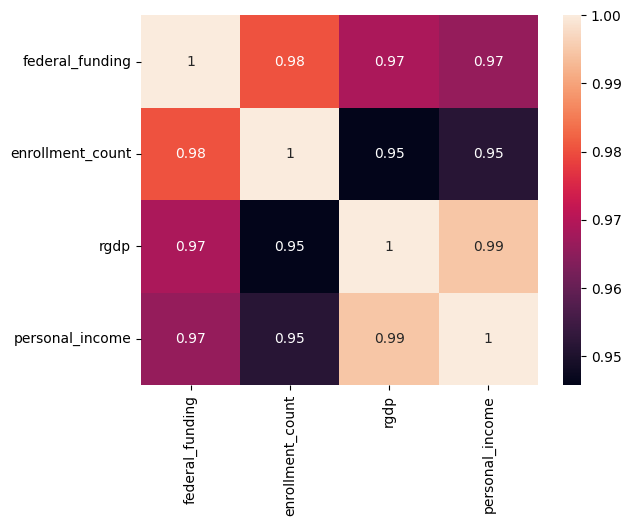

In [229]:
sns.heatmap(df_headstart_fiscal.corr(), annot=True,)

##### <b>Insight</b>
- For effective funding, each state should receive funding in proportion to its personal income and the number of children in need of Head Start. The table demonstrates strong positive correlation between federal funding, local personal income, and local enrollment count, indicating a successful funding policy is enforced across the states.

#### <b>Metric: Fund per child</b>
- Definition:  The total amount of head start program fund divided by the number of children enrolled in the head start centers within a state.
- Usage: 

- - Shows the distribution of fiscal resource across the states. 
- - Identify states that are overfunded and underfunded.

In [230]:
df_headstart_fiscal['fund_per_child'] = df_headstart_fiscal.federal_funding / df_headstart_fiscal.enrollment_count.astype(float)
df_headstart_fiscal.sort_values('fund_per_child', ascending=True).head()

,state_name,federal_funding,enrollment_count,state,rgdp,personal_income,fund_per_child
37,Oregon,105339943.000,12899,OR,254708.400,264173.800,8166.520
49,West Virginia,75200678.000,7824,WV,76525.500,88744.900,9611.539
38,Pennsylvania,355878475.000,35372,PA,772335.900,836778.300,10061.022
18,Louisiana,209932116.000,20165,LA,231262.300,250170.600,10410.717
25,Mississippi,225587275.000,21622,MS,114152.900,136330.200,10433.229


#### <b>Metric: Funding Index</b>
- Definition: The amount of Head Start funding divided by local personal income, then devided by the number of enrolled children.
- Usage: 
- - Offset the impact of local price level.
- - Measure the intensity of funding as shared by each child. (Measuring how strong the funding is when applied to an individual child)

In [231]:
df_headstart_fiscal['funding_index'] = df_headstart_fiscal.federal_funding / df_headstart_fiscal.personal_income / df_headstart_fiscal.enrollment_count
df_headstart_fiscal.sort_values('funding_index', ascending=True).head(10)

,state_name,federal_funding,enrollment_count,state,rgdp,personal_income,fund_per_child,funding_index
4,California,1320500737.000,87819,CA,3167460.800,3006647.300,15036.618,0.005
43,Texas,719676508.000,68467,TX,1924007.500,1879419.600,10511.290,0.006
9,Florida,442454135.000,40319,FL,1218430.200,1441598.900,10973.837,0.008
34,New York,626590038.000,46051,NY,1763524.600,1483802.300,13606.437,0.009
38,Pennsylvania,355878475.000,35372,PA,772335.900,836778.300,10061.022,0.012
14,Illinois,410844005.000,29117,IL,864170.900,851243.100,14110.108,0.017
35,Ohio,383581783.000,33303,OH,689681.300,679233.000,11517.935,0.017
31,New Jersey,193901043.000,15267,NJ,646731.300,714990.200,12700.664,0.018
10,Georgia,258763401.000,23259,GA,655827.300,617553.000,11125.302,0.018
45,Virginia,151962333.000,13886,VA,576964.300,599042.000,10943.564,0.018


In [232]:
df_headstart_fiscal.funding_index.describe()

count   51.000
mean     0.085
std      0.093
min      0.005
25%      0.025
50%      0.044
75%      0.115
max      0.421
Name: funding_index, dtype: float64

<AxesSubplot:>

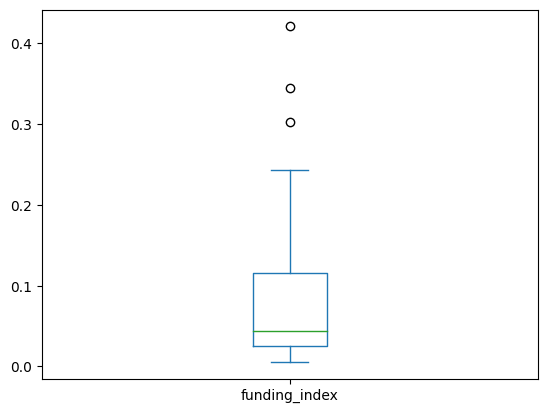

In [233]:
df_headstart_fiscal.funding_index.plot.box()

##### <b>Insight</b>
- Although the funding policy has taken into account regional economic status and enrollment, the child funding index shows that there exists inequality regarding the funding policy. In some states, the effect of funding proves stronger.
- Policy makers may review their existing funding strategy and pay more attention to the states where the funding index is low.

In [234]:
df_headstart_center = pd.read_csv('ALL_all.csv',)
df_headstart_center.head()

,addressLineOne,addressLineTwo,cid,grantNumber,delegateNumber,type,longitude,latitude,name,city,...,programAddressLineOne,programAddressLineTwo,programName,programCity,programState,programZipFive,programZipFour,programPhone,programRegistrationPhone,programIdentifier
0,11500 Joslin St,NaN,100000,09CH011157,2,1,-118.089,33.944,Lakeview (Plaza),Santa Fe Springs,...,13300 Crossroads Pkwy N,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(562) 929-6320,(562)776-1301,los_angeles_county_office_of_education_ca
1,5036 North Huntington Drive,NaN,100001,09CH011157,2,1,-118.172,34.089,El Sereno (Plaza),Los Angeles,...,13300 Crossroads Pkwy N,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(323) 222-2786,(562)776-1301,los_angeles_county_office_of_education_ca
2,2141 Workman St,NaN,100002,09CH011157,2,1,-118.214,34.071,Cedillo (Plaza),Los Angeles,...,13300 Crossroads Pkwy N,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(323) 225-9792,(562)776-1301,los_angeles_county_office_of_education_ca
3,12322 Pellissier Rd,NaN,100003,09CH011157,2,1,-118.032,34.034,Little Star (Plaza),Whittier,...,13300 Crossroads Pkwy N,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(562) 699-5655,(562)776-1301,los_angeles_county_office_of_education_ca
4,12830 Columbia Way,NaN,100004,09CH011157,2,1,-118.134,33.914,Columbia (Plaza),Downey,...,13300 Crossroads Pkwy N,Ste 440,Plaza de la Raza Child Development Services Inc.,City Of Industry,CA,91746.000,3440,(562) 803-6229,(562)776-1301,los_angeles_county_office_of_education_ca


In [235]:
df_headstart_center.columns

Index(['addressLineOne', 'addressLineTwo', 'cid', 'grantNumber',
       'delegateNumber', 'type', 'longitude', 'latitude', 'name', 'city',
       'state', 'zipFive', 'zipFour', 'phone', 'googleMapZoomLevel', 'county',
       'programCounty', 'programAddressLineOne', 'programAddressLineTwo',
       'programName', 'programCity', 'programState', 'programZipFive',
       'programZipFour', 'programPhone', 'programRegistrationPhone',
       'programIdentifier'],
      dtype='object')

In [236]:
# to perform county level analysis, we need to combine state and county so as to make it unique
df_headstart_center['state_county'] = df_headstart_center['state'] + " " + df_headstart_center['county']

In [237]:
df_headstart_center.shape, df_headstart_center.cid.nunique(), df_headstart_center.state_county.nunique()

((21334, 28), 21334, 2895)

In [238]:
df_saipe = pd.read_excel('est21all.xls',).drop(index=[0, 1])
df_saipe.head()

,Table with column headers in rows 3 and 4,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
2,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,...,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
3,00,000,US,United States,41393176,41149497,41636855,12.800,12.700,12.900,...,16.300,69717,69583,69851,3349149,3299669,3398629,18.300,18,18.600
4,01,000,AL,Alabama,800848,782169,819527,16.300,15.900,16.700,...,22.500,53990,53218,54762,71220,66888,75552,25.100,23.600,26.600
5,01,001,AL,Autauga County,6296,4772,7820,10.700,8.100,13.300,...,20.400,66444,60061,72827,.,.,.,.,.,.
6,01,003,AL,Baldwin County,25526,21599,29453,10.800,9.100,12.500,...,18.500,65658,60723,70593,.,.,.,.,.,.


In [239]:
state_names = df_state_abbr.State.tolist()
filter_out = state_names + ['United States']
df_saipe = df_saipe[~df_saipe['Unnamed: 3'].isin(filter_out)]
df_saipe.head()

,Table with column headers in rows 3 and 4,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
2,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,...,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
5,01,001,AL,Autauga County,6296,4772,7820,10.700,8.100,13.300,...,20.400,66444,60061,72827,.,.,.,.,.,.
6,01,003,AL,Baldwin County,25526,21599,29453,10.800,9.100,12.500,...,18.500,65658,60723,70593,.,.,.,.,.,.
7,01,005,AL,Barbour County,5089,3773,6405,23,17,29,...,44.600,38649,34308,42990,.,.,.,.,.,.
8,01,007,AL,Bibb County,4204,3324,5084,20.600,16.300,24.900,...,35.400,48454,42438,54470,.,.,.,.,.,.


In [240]:
def to_int(v):
    try:
        return int(v)
    except Exception as e:
        print(e)
        print(v)
        return 0
    
teen_poverty = df_saipe.iloc[1:, 10].map(to_int)
teen_poverty

young_poverty = df_saipe.iloc[1:, 16].map(to_int)
young_poverty

child_poverty = teen_poverty - young_poverty

invalid literal for int() with base 10: '.'
.
invalid literal for int() with base 10: '.'
.


In [241]:
df_child_poverty = pd.DataFrame({
    'state': df_saipe.iloc[1:, 2],
    'county': df_saipe.iloc[1:, 3],
    'county_fips': df_saipe.iloc[1:, 0],
    'child_poverty_count': child_poverty.values,    # estimated number of children in poverty
})

df_child_poverty.head()

,state,county,county_fips,child_poverty_count
5,AL,Autauga County,01,592
6,AL,Baldwin County,01,2445
7,AL,Barbour County,01,500
8,AL,Bibb County,01,335
9,AL,Blount County,01,637


In [242]:
df_child_poverty[df_child_poverty.county.str.contains('County|Parish')] # only study county level data

,state,county,county_fips,child_poverty_count
5,AL,Autauga County,01,592
6,AL,Baldwin County,01,2445
7,AL,Barbour County,01,500
8,AL,Bibb County,01,335
9,AL,Blount County,01,637
...,...,...,...,...
3193,WY,Sweetwater County,56,320
3194,WY,Teton County,56,81
3195,WY,Uinta County,56,221
3196,WY,Washakie County,56,59


In [243]:
df_child_poverty = pd.merge(df_child_poverty, df_state_abbr, left_on='state', right_on='Abbreviation', how='left',).drop(columns=['Abbreviation'])
col = df_child_poverty.columns.tolist()
col[-1] = 'state_name'
df_child_poverty.columns = col

df_child_poverty['state_county'] = df_child_poverty.state + ' ' + df_child_poverty.county
print(df_child_poverty.shape, df_child_poverty.state_county.nunique()   )
df_child_poverty.head()

(3142, 6) 3142


,state,county,county_fips,child_poverty_count,state_name,state_county
0,AL,Autauga County,01,592,Alabama,AL Autauga County
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County
2,AL,Barbour County,01,500,Alabama,AL Barbour County
3,AL,Bibb County,01,335,Alabama,AL Bibb County
4,AL,Blount County,01,637,Alabama,AL Blount County


##### <b>Metric: Children per Center (CPC)</b>
- Definition: The number of enrolled children divided by the number of centers. Can be calculated at either county or state level. In this analysis it is calculated at county level.
- Usage: 

- - Evaluate the average workload of head start centers within a region. If the metric goes too high, the children in the corresponding area may be underserved because the resources are shared by too many children. If the metric goes too low, the centers in the corresponding area may not be fully utilized.

In [244]:
df_headstart_fiscal.head()

,state_name,federal_funding,enrollment_count,state,rgdp,personal_income,fund_per_child,funding_index
0,Alaska,20579547.000,1348,AK,50315.100,50349.700,15266.726,0.303
1,Alabama,156825889.000,13438,AL,235807.300,258362.200,11670.330,0.045
2,Arkansas,106372981.000,9191,AR,137355.500,160254.200,11573.603,0.072
3,Arizona,175213573.000,13054,AZ,403474.200,430083.500,13422.213,0.031
4,California,1320500737.000,87819,CA,3167460.800,3006647.300,15036.618,0.005


In [245]:
def get_child_per_center(children:float, centers: float):
    if centers == 0 or centers == np.nan:
        return np.nan
    return round(children / centers, 5)


def find_county_cpc(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    count_children = df_child_poverty.loc[index, 'child_poverty_count']
    count_centers = df_headstart_center[df_headstart_center.state_county == state_county].shape[0]
    return get_child_per_center(count_children, count_centers)


def find_state_cpc(index):
    state = df_child_poverty.loc[index, 'state']
    count_enrolled_children = df_headstart_fiscal[df_headstart_fiscal.state == state].enrollment_count.values[0]
    count_centers = df_headstart_center[df_headstart_center.state == state].shape[0]
    return get_child_per_center(count_enrolled_children, count_centers)


def check_has_center(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    count_centers = df_headstart_center[df_headstart_center.state_county == state_county].shape[0]
    return count_centers > 0


df_child_poverty['cpc'] = df_child_poverty.index.map(find_county_cpc)
df_child_poverty['has_center'] = df_child_poverty.index.map(check_has_center)
df_child_poverty['state_cpc'] = df_child_poverty.index.map(find_state_cpc)
df_child_poverty.head()

,state,county,county_fips,child_poverty_count,state_name,state_county,cpc,has_center,state_cpc
0,AL,Autauga County,01,592,Alabama,AL Autauga County,296.000,True,42.125
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County,489.000,True,42.125
2,AL,Barbour County,01,500,Alabama,AL Barbour County,500.000,True,42.125
3,AL,Bibb County,01,335,Alabama,AL Bibb County,335.000,True,42.125
4,AL,Blount County,01,637,Alabama,AL Blount County,127.400,True,42.125


In [246]:
df_child_poverty.shape[0], df_child_poverty.county.nunique() # counties may have same name but different state

(3142, 1877)

In [247]:
df_county_boundaries = pd.read_html('https://en.wikipedia.org/wiki/User:Michael_J/County_table')[0].iloc[:, 1:]

In [248]:
def to_float(s):
    try:
        return float(s.replace('–', '-'))
    except Exception as e:
        print(e)
        print(s)
        return 0


col = df_county_boundaries.columns.map(lambda s: s.lower()).tolist()
col[2] = 'county'
df_county_boundaries.columns = col
df_county_boundaries.latitude = df_county_boundaries.latitude.map(lambda s: to_float(s[:-1]))
df_county_boundaries.longitude = df_county_boundaries.longitude.map(lambda s: to_float(s[:-1]))
df_county_boundaries.head()

,state,fips,county,county seat(s) [3],population(2010),land areakm²,land areami²,water areakm²,water areami²,total areakm²,total areami²,latitude,longitude
0,AL,1001,Autauga,Prattville,54571,1539.582,594.436,25.776,9.952,1565.358,604.388,32.536,-86.644
1,AL,1003,Baldwin,Bay Minette,182265,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,30.659,-87.746
2,AL,1005,Barbour,Clayton,27457,2291.819,884.876,50.865,19.639,2342.684,904.515,31.871,-85.405
3,AL,1007,Bibb,Centreville,22915,1612.481,622.582,9.289,3.587,1621.770,626.169,33.016,-87.127
4,AL,1009,Blount,Oneonta,57322,1669.962,644.776,15.157,5.852,1685.119,650.628,33.977,-86.567


In [249]:
df_county_boundaries['state_county'] = df_county_boundaries.state + ' ' + df_county_boundaries.county + " County"
df_child_poverty = pd.merge(df_child_poverty, df_county_boundaries[['state_county', 'latitude', 'longitude']], on='state_county', how='left')
df_child_poverty.head()

,state,county,county_fips,child_poverty_count,state_name,state_county,cpc,has_center,state_cpc,latitude,longitude
0,AL,Autauga County,01,592,Alabama,AL Autauga County,296.000,True,42.125,32.536,-86.644
1,AL,Baldwin County,01,2445,Alabama,AL Baldwin County,489.000,True,42.125,30.659,-87.746
2,AL,Barbour County,01,500,Alabama,AL Barbour County,500.000,True,42.125,31.871,-85.405
3,AL,Bibb County,01,335,Alabama,AL Bibb County,335.000,True,42.125,33.016,-87.127
4,AL,Blount County,01,637,Alabama,AL Blount County,127.400,True,42.125,33.977,-86.567


In [250]:
no_pos_state_county = df_child_poverty[df_child_poverty.latitude.isna() | df_child_poverty.longitude.isna()]['state_county']
df_avg_pos = df_headstart_center[df_headstart_center.state_county.isin(no_pos_state_county)].groupby('state_county').agg({'latitude': 'mean', 'longitude': 'mean'})


def find_lat(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    if state_county not in df_avg_pos.index:
        return np.nan
    lat = df_avg_pos.loc[state_county, 'latitude']
    return lat

def find_long(index):
    state_county = df_child_poverty.loc[index, 'state_county']
    if state_county not in df_avg_pos.index:
        return np.nan
    long = df_avg_pos.loc[state_county, 'longitude']
    return long

df_child_poverty.loc[df_child_poverty.latitude.isna(), 'latitude'] = df_child_poverty[df_child_poverty.latitude.isna()].index.map(find_lat)
df_child_poverty.loc[df_child_poverty.longitude.isna(), 'longitude'] = df_child_poverty[df_child_poverty.longitude.isna()].index.map(find_long)
df_child_poverty.latitude.isna().sum(), df_child_poverty.longitude.isna().sum()

(32, 32)

In [251]:
df_child_poverty = df_child_poverty[~(df_child_poverty.latitude.isna() | df_child_poverty.longitude.isna()) & df_child_poverty.state_county.str.contains('County|Parish')]
df_child_poverty.shape

(3063, 11)

In [252]:
df_child_poverty.latitude.isna().sum(), df_child_poverty.longitude.isna().sum()

(0, 0)

##### <b>Metric: Center Coverage Rate</b>
- Definition: The number of regions where head start is available divided by the number of regions. The regions can be either county, state, or other well-defined unit. In our analysis it is calculated at county level.
- Usage: 
- - Gives an overall idea of the accessibility of head start program across the nation.

In [253]:
df_child_poverty.has_center.mean()  # county level center coverage rate

0.8971596474045054

##### <b>Metric: Enrollment Rate</b>
- Definition: The number of children enrolled in the head start centers of a county divided by the estimated number of children in poverty in the same county. (Can also be calculated at other geospatial scope such as state level)
- Usage: 
- - Shows how many community members are actually participating in the head start program in a county.

In [254]:
df_headstart_fiscal.head()

,state_name,federal_funding,enrollment_count,state,rgdp,personal_income,fund_per_child,funding_index
0,Alaska,20579547.000,1348,AK,50315.100,50349.700,15266.726,0.303
1,Alabama,156825889.000,13438,AL,235807.300,258362.200,11670.330,0.045
2,Arkansas,106372981.000,9191,AR,137355.500,160254.200,11573.603,0.072
3,Arizona,175213573.000,13054,AZ,403474.200,430083.500,13422.213,0.031
4,California,1320500737.000,87819,CA,3167460.800,3006647.300,15036.618,0.005


In [255]:
df_state_child_poverty = df_child_poverty.groupby('state')['child_poverty_count'].sum().to_frame()
df_state_child_poverty.reset_index(inplace=True)
df_state_child_poverty = pd.merge(df_state_child_poverty, df_state_abbr, left_on='state',  right_on='Abbreviation', how='left').drop(columns=['Abbreviation'])
col = df_state_child_poverty.columns.tolist()
col[-1] = 'state_name'
df_state_child_poverty.columns = col
df_state_child_poverty = pd.merge(
    df_state_child_poverty, df_headstart_fiscal, on='state', how='left', suffixes=('', '_headstart')).drop(columns=['state_name_headstart']
    )
df_state_child_poverty['enroll_rate'] = df_state_child_poverty.enrollment_count.astype(float) / df_state_child_poverty.child_poverty_count.astype(float)
df_state_child_poverty.sort_values('enroll_rate', ascending=True).head()

,state,child_poverty_count,state_name,federal_funding,enrollment_count,rgdp,personal_income,fund_per_child,funding_index,enroll_rate
31,NV,38827,Nevada,41621944.000,2937,187226.200,197290.900,14171.585,0.072,0.076
11,ID,19157,Idaho,38883862.000,2908,91683.700,109775.900,13371.342,0.122,0.152
2,AZ,83855,Arizona,175213573.000,13054,403474.200,430083.500,13422.213,0.031,0.156
8,GA,143901,Georgia,258763401.000,23259,655827.300,617553.000,11125.302,0.018,0.162
41,TX,414914,Texas,719676508.000,68467,1924007.500,1879419.600,10511.290,0.006,0.165


In [256]:
df_child_poverty.to_csv('child_poverty_merged_10-22.csv', index=False)
df_state_child_poverty.to_csv('enroll_and_fund.csv', index=False)

##### <b>Distribution of Children per Center</b>
- Skewed to the right, meaning that there are few counties with abnormaly high figures of children per center. 

<AxesSubplot:>

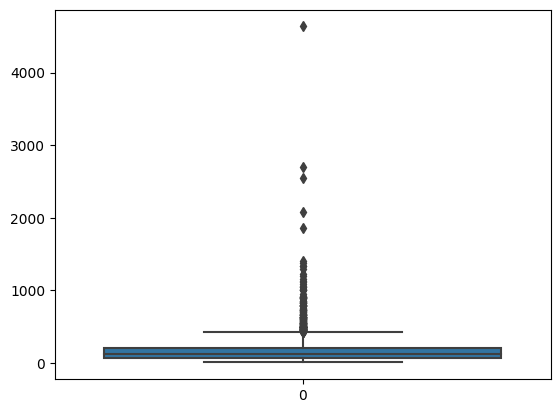

In [257]:
sns.boxplot(df_child_poverty['cpc'],)

In [258]:
df_child_poverty.cpc.describe()

count   2748.000
mean     174.692
std      202.530
min        5.667
25%       67.394
50%      120.342
75%      211.808
max     4635.000
Name: cpc, dtype: float64

In [259]:
df_child_poverty[['cpc','state', 'state_county']].sort_values(ascending=False, by='cpc' ).head(10)

,cpc,state,state_county
2583,4635.000,TX,TX Denton County
2645,2693.000,TX,TX Jefferson County
2565,2543.000,TX,TX Collin County
419,2078.667,GA,GA Cobb County
1954,1857.000,NC,NC New Hanover County
453,1406.429,GA,GA Gwinnett County
1214,1383.000,MD,MD Wicomico County
455,1333.000,GA,GA Hall County
461,1331.500,GA,GA Henry County
2692,1287.000,TX,TX Montgomery County


##### <b>Insight and Policy Suggestion</b>
- As shown, there are many Head Start centers in Texas and Georgia that have abnormaly high child per center values.
- Agencies and program managers may need to focus on those counties and states and try to provide more resource so as to serve the communities there.

##### <b>Distribution of Funding Index</b>
- Skewed to the right, meaning that there are few states where the intensity of funding is significantly higher than all the other states.

<AxesSubplot:>

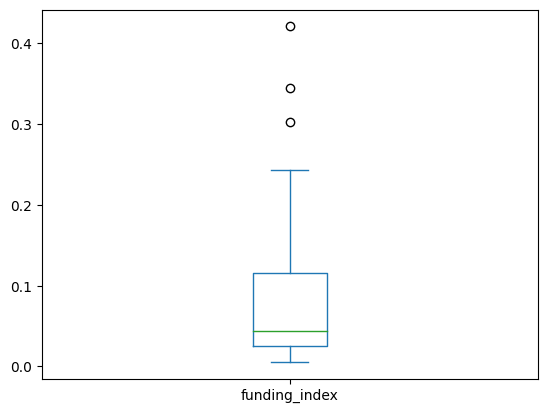

In [260]:
df_headstart_fiscal.funding_index.plot.box()

In [261]:
df_headstart_fiscal.funding_index.describe()

count   51.000
mean     0.085
std      0.093
min      0.005
25%      0.025
50%      0.044
75%      0.115
max      0.421
Name: funding_index, dtype: float64

##### <b>Insight and Policy Suggestion</b>
- As shown, there are many Head Start centers in Texas and Georgia that have abnormaly high child per center values.
- To better facilitate equity and accessibility, policy makers may consider to rebalance the current funding policy to reduce the difference of funding index across the states.

#### <b>An Econometric Model for the Relationship between Head Start Funding, Enrollment, and Income Level

In [262]:
md = LinearRegression()
X = df_headstart_fiscal[['enrollment_count']]
y = df_headstart_fiscal.federal_funding
md.fit(X, y)
r2 = md.score(X, y)

n = len(y)
p = X.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'r2: {r2}, r2_adj: {r2_adj}')
print(md.coef_, md.intercept_)

r2: 0.9613741875288951, r2_adj: 0.9605859056417297
[12952.71182254] -11489485.076242745


In [263]:
md = LinearRegression()
X = df_headstart_fiscal[['enrollment_count', 'personal_income']]
y = df_headstart_fiscal.federal_funding
md.fit(X, y)
r2 = md.score(X, y)

n = len(y)
p = X.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'r2: {r2}, r2_adj: {r2_adj}')
print(md.coef_, md.intercept_)

r2: 0.9728542678014624, r2_adj: 0.9717231956265234
[8570.99031496  145.2116273 ] -8447785.96442923


- Enrollment alone can determine to a very large extent the funding received by a state.
- Personal income can further improve the model's R2 score, showing significant impact on the funding. The positive coefficient of income also suggests that funding granted to each state were adjusted slightly based on local price level.

In [264]:
df_headstart_fiscal.head()

,state_name,federal_funding,enrollment_count,state,rgdp,personal_income,fund_per_child,funding_index
0,Alaska,20579547.000,1348,AK,50315.100,50349.700,15266.726,0.303
1,Alabama,156825889.000,13438,AL,235807.300,258362.200,11670.330,0.045
2,Arkansas,106372981.000,9191,AR,137355.500,160254.200,11573.603,0.072
3,Arizona,175213573.000,13054,AZ,403474.200,430083.500,13422.213,0.031
4,California,1320500737.000,87819,CA,3167460.800,3006647.300,15036.618,0.005


In [265]:
df_foo = pd.merge(df_state_child_poverty, df_child_poverty.groupby('state')['state_cpc'].sum().to_frame(), on='state', how='right')
df_foo.head()

,state,child_poverty_count,state_name,federal_funding,enrollment_count,rgdp,personal_income,fund_per_child,funding_index,enroll_rate,state_cpc
0,AL,73733,Alabama,156825889.000,13438,235807.300,258362.200,11670.330,0.045,0.182,2822.401
1,AR,47630,Arkansas,106372981.000,9191,137355.500,160254.200,11573.603,0.072,0.193,2174.527
2,AZ,83855,Arizona,175213573.000,13054,403474.200,430083.500,13422.213,0.031,0.156,403.732
3,CA,369418,California,1320500737.000,87819,3167460.800,3006647.300,15036.618,0.005,0.238,2190.753
4,CO,44499,Colorado,119296359.000,9489,416114.400,442213.000,12572.069,0.028,0.213,1796.733


In [266]:
import plotly.express as px

x_label = 'state cpc'
y_label = 'enroll rate'
z_label = 'funding index'

x = df_foo.state_cpc.values
y = df_foo.enroll_rate.values
z = df_foo.funding_index.values

df = pd.DataFrame( {
    x_label: x,
    y_label: y,
    z_label: z
})

# Create the 3D scatter plot
fig = px.scatter_3d(df, x=x, y=y, z=z, color=df_foo.state,)

# Customize the layout (optional)
fig.update_layout(
    scene=dict(
        xaxis_title=x_label,
        yaxis_title=y_label,
        zaxis_title=z_label
    )
)

# Show the plot
fig.show()
